<a href="https://colab.research.google.com/github/mabataki2/AI-Class/blob/main/Week11/AE_WISDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# ================================================
# AutoEncoder 기반 이상탐지 (Jogging vs Sitting)
# =============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [10]:

# 파일 경로 (업로드된 파일 사용)
file_path = '/content/drive/MyDrive/WISDM.csv'

# 컬럼명 지정 및 데이터 타입 최적화
data_types = {
    'User': 'int16',
    'Activity': 'category',
    'Timestamp': 'float64', # Timestamp는 정밀도를 위해 float64 유지
    'X': 'object',
    'Y': 'object',
    'Z': 'object'
}

try:
    # 대용량 파일이므로, 전체 로드 대신 일부만 로드하는 것을 고려
    # 여기서는 메모리 효율화를 위해 데이터 타입을 지정하여 전체 로드 시도
    df = pd.read_csv(
        file_path,
        sep=',',
        names=['Index', 'User', 'Activity', 'Timestamp', 'X', 'Y', 'Z'],
        dtype=data_types,
        skiprows=1 # 헤더 행(첫 번째 인덱스) 제거
    ).drop('Index', axis=1) # 로드 시 생성된 인덱스 컬럼 제거

except Exception as e:
    print(f"Error: 파일 로드 실패 - {e}")
    exit()

# ⚠️ 'X', 'Y', 'Z' 컬럼 정리
print("가속도계 데이터 정리 시작...")
for col in ['X', 'Y', 'Z']:
    # 세미콜론(;) 제거 후 float32로 변환하여 메모리 최적화
    df[col] = df[col].astype(str).str.replace(';', '').astype(np.float32)

# --- 이상 탐지 분석을 위한 데이터 필터링 ---
# 정상(Normal) 데이터: Sitting
# 이상(Anomaly) 데이터: Jogging
normal_activity = 'Sitting'
anomaly_activity = 'Jogging'

# 데이터 샘플링 (런타임 종료 방지 및 학습 시간 단축)
# Sitting과 Jogging 데이터만 추출
df_subset = df[df['Activity'].isin([normal_activity, anomaly_activity])]
# 약 100만 행으로 제한
if len(df_subset) > 1000000:
    df_subset = df_subset.sample(n=1000000, random_state=42).sort_index()

# 학습에 사용할 특성(Features)
features = ['X', 'Y', 'Z']

# 정상 데이터셋 (AutoEncoder 학습용)
df_normal = df_subset[df_subset['Activity'] == normal_activity]
X_normal = df_normal[features].values

# 이상/정상 포함 테스트 데이터셋 (성능 평가용)
X_test = df_subset[features].values
Y_test = (df_subset['Activity'] == anomaly_activity).astype(int).values # 이상 데이터(Jogging): 1, 정상 데이터(Sitting): 0

# --- 데이터 스케일링 ---
scaler = StandardScaler()

# 정상 데이터로만 스케일러 학습 및 변환
X_normal_scaled = scaler.fit_transform(X_normal)
print(f"정상 데이터(Sitting) 학습 데이터 크기: {X_normal_scaled.shape}")

# 테스트 데이터 변환
X_test_scaled = scaler.transform(X_test)
print(f"테스트 데이터 크기: {X_test_scaled.shape}")

가속도계 데이터 정리 시작...
정상 데이터(Sitting) 학습 데이터 크기: (54876, 3)
테스트 데이터 크기: (380850, 3)


In [11]:
# --- AutoEncoder 모델 정의 ---
input_dim = X_normal_scaled.shape[1] # 3 (X, Y, Z)
encoding_dim = 2 # 잠재 공간(Hidden Layer) 차원: 2차원

# 1. 인코더 (Encoder)
input_layer = Input(shape=(input_dim,))
# 입력층 (3) -> 히든층1 (10) -> 잠재 공간 (2)
encoder = Dense(10, activation="relu")(input_layer)
encoder_output = Dense(encoding_dim, activation="relu")(encoder)

# 2. 디코더 (Decoder)
# 잠재 공간 (2) -> 히든층2 (10) -> 출력층 (3)
decoder = Dense(10, activation="relu")(encoder_output)
decoder_output = Dense(input_dim, activation='linear')(decoder)

# AutoEncoder 모델
autoencoder = Model(inputs=input_layer, outputs=decoder_output)

# 3. 모델 컴파일 및 학습
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 조기 종료(Early Stopping) 설정: 5 에포크 동안 loss가 개선되지 않으면 중지
callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("AutoEncoder 학습 시작...")
history = autoencoder.fit(
    X_normal_scaled,
    X_normal_scaled, # 입력과 출력이 동일 (재구성)
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.1, # 검증 데이터 분리
    callbacks=[callback],
    verbose=1
)

print("AutoEncoder 학습 완료.")

#

AutoEncoder 학습 시작...
Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.8602 - val_loss: 0.0801
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2723 - val_loss: 0.1149
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0771 - val_loss: 0.0880
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0442 - val_loss: 0.0903
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0328 - val_loss: 0.0749
Epoch 6/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0283 - val_loss: 0.0741
Epoch 7/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0256 - val_loss: 0.0703
Epoch 8/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0231 - val_loss: 0.0690
Epoch 9/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0201 - val_loss: 0.0713
Epoch 10/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0183 - val_loss: 0.0738
Epoch 11/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0175 - val_loss: 0.0769
Epoch 12/50
386/386 ━━━━━━━━━━━

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

# --- 재구성 오차 계산 ---
# 테스트 데이터셋에 대해 AutoEncoder를 실행
X_test_pred = autoencoder.predict(X_test_scaled)
# 원본과 재구성된 데이터 간의 MSE(Mean Squared Error) 계산
mse = np.mean(np.power(X_test_scaled - X_test_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_Error': mse, 'True_Class': Y_test})

# --- 임계값(Threshold) 결정 ---
# 정상 데이터(Sitting, True_Class=0)의 오차 분포 확인
normal_error = error_df[error_df['True_Class'] == 0]['Reconstruction_Error']

# 임계값: 정상 데이터 오차의 95% 분위수 또는 특정 값 (여기서는 99% 분위수로 보수적 설정)
threshold = np.quantile(normal_error, 0.99)
print(f"\n정상 데이터(Sitting)의 99% 분위수 재구성 오차 (임계값): {threshold:.4f}")

# --- 성능 평가 ---
# 임계값을 초과하면 이상(1), 아니면 정상(0)으로 분류
y_pred = (error_df['Reconstruction_Error'] > threshold).astype(int)

# AUC-ROC 계산
auc_score = roc_auc_score(error_df['True_Class'], error_df['Reconstruction_Error'])
print(f"AUC-ROC Score: {auc_score:.4f}")

# 분류 결과 출력
print("\n--- Confusion Matrix (임계값 초과 = 이상) ---")
print(confusion_matrix(error_df['True_Class'], y_pred))

# 분류 보고서
print("\n--- Classification Report ---")
print(classification_report(error_df['True_Class'], y_pred, target_names=['Sitting (Normal)', 'Jogging (Anomaly)']))

11902/11902 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step

정상 데이터(Sitting)의 99% 분위수 재구성 오차 (임계값): 0.2960
AUC-ROC Score: 0.9839

--- Confusion Matrix (임계값 초과 = 이상) ---
[[ 54336    540]
 [ 64483 261491]]

--- Classification Report ---
                   precision    recall  f1-score   support

 Sitting (Normal)       0.46      0.99      0.63     54876
Jogging (Anomaly)       1.00      0.80      0.89    325974

         accuracy                           0.83    380850
        macro avg       0.73      0.90      0.76    380850
     weighted avg       0.92      0.83      0.85    380850



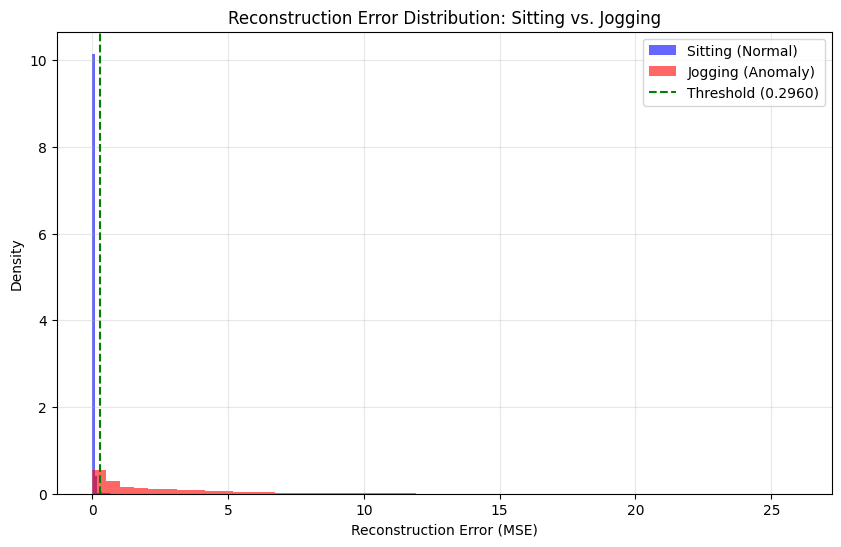

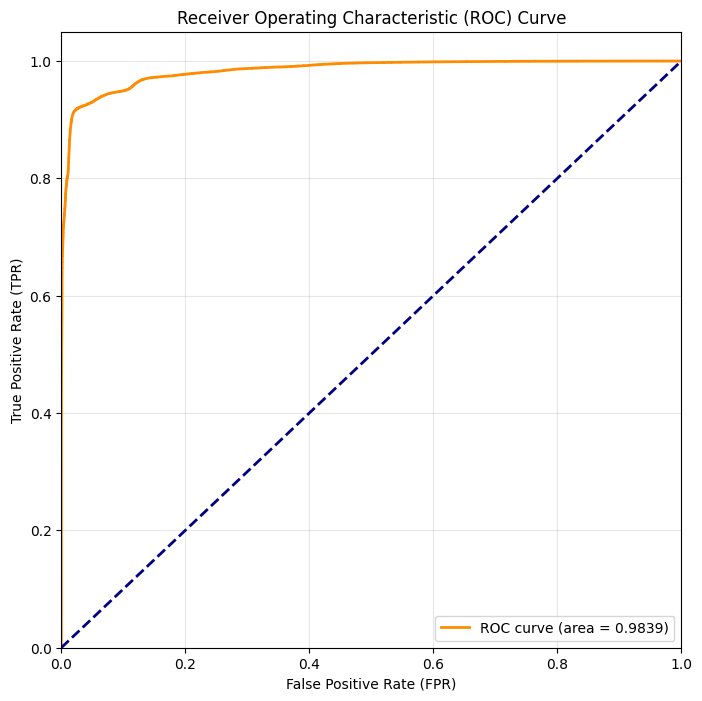

In [13]:
# --- 재구성 오차 분포 시각화 ---
plt.figure(figsize=(10, 6))
# 정상 데이터 오차
plt.hist(error_df[error_df['True_Class'] == 0]['Reconstruction_Error'], bins=50, density=True, label='Sitting (Normal)', alpha=0.6, color='blue')
# 이상 데이터 오차
plt.hist(error_df[error_df['True_Class'] == 1]['Reconstruction_Error'], bins=50, density=True, label='Jogging (Anomaly)', alpha=0.6, color='red')

# 임계값 선
plt.axvline(threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.4f})')

plt.title('Reconstruction Error Distribution: Sitting vs. Jogging')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- ROC 곡선 시각화 ---
fpr, tpr, _ = roc_curve(error_df['True_Class'], error_df['Reconstruction_Error'])

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()